# Detecting COVID-19 and Viral Pneumonia with Chest X Ray and Lung Segmentation Mask using PyTorch By Fahm-Ul-Islam


Image classification of Chest X Rays in one of 3 classes: Normal, COVID-19, Viral Pneumonia

Dataset from [COVID-QU-Ex Dataset](https://www.kaggle.com/datasets/anasmohammedtahir/covidqu) on Kaggle

# Importing Libraries

In [ ]:

from matplotlib import pyplot as plt
from PIL import Image
import torchvision
import numpy as np
import shutil
import random
import torch
import torch.nn as nn

import os
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

%matplotlib inline

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

# to find the index of your GPU in PyTorch:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU device index: {torch.cuda.current_device()}")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU instead.")

#To check if your PyTorch code has been built with GPU support, you can use the following code:

print(torch.version.cuda)  # This will print the version of CUDA used by PyTorch
print(torch.cuda.is_available())  # This will print whether PyTorch has access to a GPU
print(torch.backends.cudnn.enabled)  # This will print whether the cuDNN library is enabled for GPU acceleration

#For TensorFlow, you can use the following code to check if your code is using GPU:




Using PyTorch version 2.0.1
GPU device index: 0
11.8
True
True


# Preparing Training and Test Sets

# Creating Custom Dataset

In [ ]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name): #Verificar se o aquivo realmente é imagem 'png'
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images

        self.images = {}
        self.class_names = ['normal', 'covid', 'non-covid']

        for c in self.class_names:
            self.images[c] = get_images(c)

        self.image_dirs = image_dirs
        self.transform = transform

    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])

    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index%len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Image Transformations

In [ ]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.RandomRotation(30),
    torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
val_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.RandomRotation(30),
    torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.RandomRotation(30),
    torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Prepare DataLoader

In [ ]:
train_dirs = {
    'normal': 'C:/Users/shorb/PycharmProjects/thesis/COVID-QU-Ex dataset/Train/Normal/images',
    'covid': 'C:/Users/shorb/PycharmProjects/thesis/COVID-QU-Ex dataset/Train/COVID-19/images',
    'non-covid' : 'C:/Users/shorb/PycharmProjects/thesis/COVID-QU-Ex dataset/Train/Non-COVID/images'
}

In [ ]:
train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 6849 normal examples
Found 7658 covid examples
Found 7208 non-covid examples


In [ ]:
test_dirs = {
     'normal': 'C:/Users/shorb/PycharmProjects/thesis/COVID-QU-Ex dataset/Test/Normal/images',
    'covid': 'C:/Users/shorb/PycharmProjects/thesis/COVID-QU-Ex dataset/Test/COVID-19/images',
    'non-covid' : 'C:/Users/shorb/PycharmProjects/thesis/COVID-QU-Ex dataset/Test/Non-COVID/images'
}

In [ ]:
test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 2140 normal examples
Found 2395 covid examples
Found 2253 non-covid examples


In [ ]:
val_dirs = {
 'normal': 'C:/Users/shorb/PycharmProjects/thesis/COVID-QU-Ex dataset/Val/Normal/images',
    'covid': 'C:/Users/shorb/PycharmProjects/thesis/COVID-QU-Ex dataset/Val/COVID-19/images',
    'non-covid' : 'C:/Users/shorb/PycharmProjects/thesis/COVID-QU-Ex dataset/Val/Non-COVID/images'
}

In [ ]:
val_dataset = ChestXRayDataset(val_dirs, val_transform)

Found 1712 normal examples
Found 1903 covid examples
Found 1802 non-covid examples


In [ ]:
batch_size = 32


dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
dl_val = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


print('Number of training batches:', len(dl_train))
print('Number of test batches:', len(dl_test))
print('Number of test batches:', len(dl_val))

Number of training batches: 679
Number of test batches: 213
Number of test batches: 170


# Creating the Model

In [ ]:
vgg16 = torchvision.models.vgg16(pretrained = True)



print(vgg16)




C:\ProgramData\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
from tabulate import tabulate

vgg16 = torchvision.models.vgg16(pretrained = True)
# Replace the last fully connected layer to have 3 output features
num_features = vgg16.classifier[-1].in_features
vgg16.classifier[-1] = nn.Linear(num_features, 3)

# Add dropout layer after the first fully connected layer
vgg16.classifier[0] = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.8),
)

# Set loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg16.parameters(), lr = 0.45e-5)


# Create a table to store layer details
table = []
for i, module in enumerate(vgg16.classifier):
    layer_name = module.__class__.__name__
    input_shape = f"({module.in_features})" if hasattr(module, 'in_features') else "-"
    output_shape = f"({module.out_features})" if hasattr(module, 'out_features') else "-"
    num_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

    # Get additional parameters for specific layers
    extra_params = ""
    if isinstance(module, torch.nn.Dropout):
        extra_params = f"p={module.p}"
    elif isinstance(module, torch.nn.ReLU):
        extra_params = ""

    table.append([i+1, layer_name, input_shape, output_shape, num_params, extra_params])

# Print the table
headers = ["Layer", "Layer Type", "Input Shape", "Output Shape", "Number of Parameters", "Additional Parameters"]
print(tabulate(table, headers=headers, tablefmt="grid"))

# Calculate the total parameters, trained parameters, and non-trained parameters
total_params = sum(p.numel() for p in vgg16.parameters())
trained_params = sum(p.numel() for p in vgg16.parameters() if p.requires_grad)
non_trained_params = total_params - trained_params

# Print the parameter information
param_info = [
    ["Total Parameters", "{:,}".format(total_params)],
    ["Trained Parameters", "{:,}".format(trained_params)],
    ["Non-Trained Parameters", "{:,}".format(non_trained_params)]
]
print()
print(tabulate(param_info, tablefmt="grid"))



+---------+--------------+---------------+----------------+------------------------+-------------------------+
|   Layer | Layer Type   | Input Shape   | Output Shape   |   Number of Parameters | Additional Parameters   |
+=========+==============+===============+================+========================+=========================+
|       1 | Sequential   | -             | -              |              102764544 |                         |
+---------+--------------+---------------+----------------+------------------------+-------------------------+
|       2 | ReLU         | -             | -              |                      0 |                         |
+---------+--------------+---------------+----------------+------------------------+-------------------------+
|       3 | Dropout      | -             | -              |                      0 | p=0.5                   |
+---------+--------------+---------------+----------------+------------------------+-------------------------+
|

# Training the Model

In [ ]:
import torch.backends.cudnn as cudnn

def train(epochs):
    print('Starting training..')

    # Check if GPU is available
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print('Using GPU:', torch.cuda.get_device_name())
    else:
        device = torch.device('cpu')
        print('GPU not available, using CPU..')

    # Move model to device
    vgg16.to(device)

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    # Enable cuDNN benchmark mode
    torch.backends.cudnn.benchmark = True

    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.0
        val_loss = 0.0
        train_acc = 0.0
        val_acc = 0.0

        # Set model to training phase
        vgg16.train()

        for train_step, (images, labels) in enumerate(dl_train):
            # Move data to device
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = vgg16(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_acc += torch.sum(preds == labels.data).item()

        train_loss /= (train_step + 1)
        train_acc /= len(dl_train.dataset)

        print(f'Training Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}')

        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Set model to evaluation phase
        vgg16.eval()
        with torch.no_grad():
            for val_step, (images, labels) in enumerate(dl_val):
                # Move data to device
                images = images.to(device)
                labels = labels.to(device)

                outputs = vgg16(images)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                val_acc += torch.sum(preds == labels.data).item()

            val_loss /= (val_step + 1)
            val_acc /= len(dl_val.dataset)

            print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')

            val_losses.append(val_loss)
            val_accs.append(val_acc)

    # Save the trained model
    save_path = r"C:\Users\shorb\PycharmProjects\thesis\metric\Models\Vgg16.pth"
    torch.save(vgg16.state_dict(), save_path)

    print('Training complete..')


In [ ]:
# %%time
# train(epochs=50)


# Final Results

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import torch
import re


def evaluate_model(model_path, epochs):
    # Load the saved model
    state_dict = torch.load(model_path)
    model = vgg16
    model.load_state_dict(state_dict)

    # Move model to device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Load the test data
    test_loader = dl_val  # Load your test dataset using a DataLoader object

    # Set model to evaluation mode
    model.eval()

    # Get the predictions and true labels for the test set
    test_preds = []
    test_labels = []
    test_scores = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs.data, 1)
            test_preds += preds.tolist()
            test_labels += labels.tolist()
            test_scores += torch.softmax(outputs, dim=1).tolist()

    # Generate the confusion matrix and classification report
    cm = confusion_matrix(test_labels, test_preds)
    class_names = ['normal', 'COVID-19', 'Pneumonia']
    cr = classification_report(test_labels, test_preds, target_names=class_names)

    # Calculate the false positive rate, true positive rate, and threshold for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i, class_name in enumerate(class_names):
        label_i = [1 if label == i else 0 for label in test_labels]
        pred_i = [score[i] for score in test_scores]
        fpr[i], tpr[i], _ = roc_curve(label_i, pred_i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curves
    plt.figure(figsize=(10, 8))
    lw = 2
    colors = ['blue', 'red', 'green']
    class_names = ['Normal', 'COVID-19', 'Pneumonia']
    for i, color in zip(range(len(class_names)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve for {} (area = {:0.2f})'.format(class_names[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png', dpi=300)
    plt.show()

    # Plot the confusion matrix heatmap
    plt.figure(figsize=(10, 8))
    ax = plt.gca()
    sns.set(font_scale=1.4)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title('Confusion Matrix')
    plt.savefig('confusion_matrix.png', dpi=300)
    plt.show()

    # Print the classification report
    print('Classification Report:\n', cr)


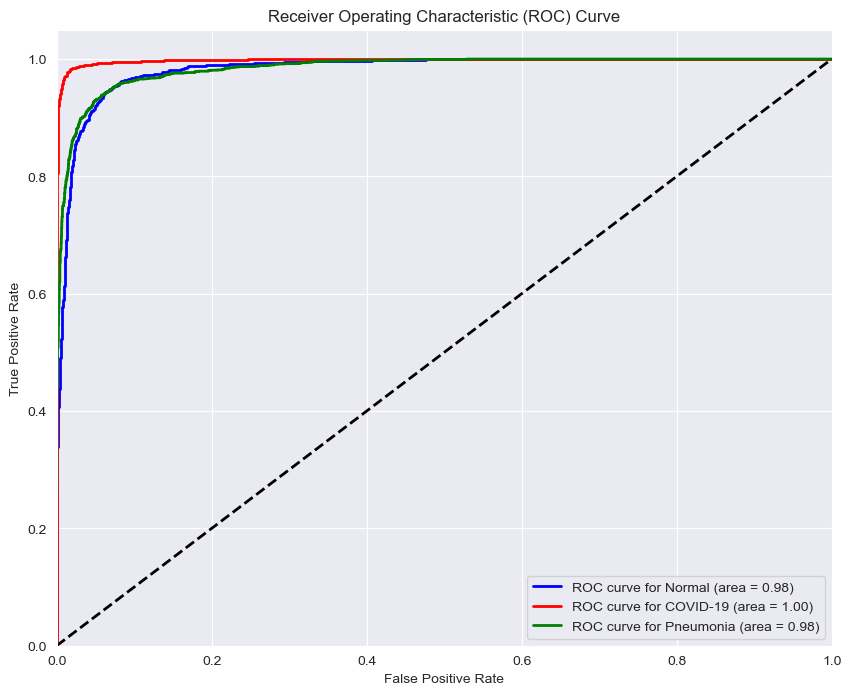

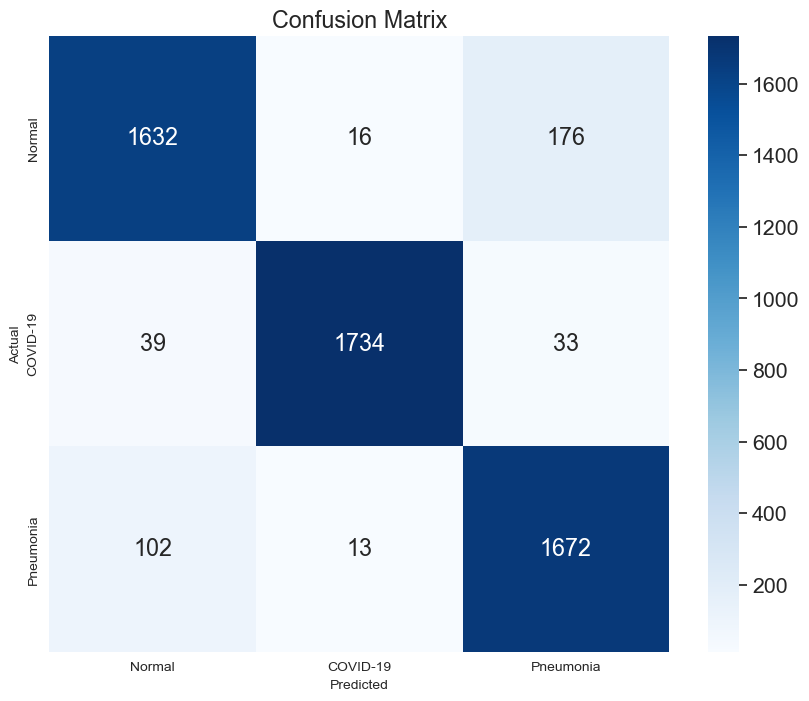

Classification Report:
               precision    recall  f1-score   support

      normal       0.92      0.89      0.91      1824
    COVID-19       0.98      0.96      0.97      1806
   Pneumonia       0.89      0.94      0.91      1787

    accuracy                           0.93      5417
   macro avg       0.93      0.93      0.93      5417
weighted avg       0.93      0.93      0.93      5417



In [ ]:
model_path = r"C:\Users\shorb\PycharmProjects\thesis\metric\Models\Shoms_Models\Vgg16.pth"
evaluate_model(model_path, 100)